# Auto Encoder

In [12]:
!unzip -q "ratings.zip"

unzip:  cannot find or open ratings.zip, ratings.zip.zip or ratings.zip.ZIP.


In [1]:
import os
import pandas as pd

# os.remove('ratings.zip')
df = pd.read_csv('ratings.csv')
df.head()

,userid,movieid,rating,timestamp
0,315543,1,10,2014-03-04 04:15:18+02
1,315551,7153,10,2015-11-22 00:29:19+02
2,315579,260,8,2015-10-02 05:10:44+02
3,315582,1236,10,1999-10-02 13:58:39+02
4,315584,2939,8,1999-12-25 09:26:45+02


In [2]:
df.drop(columns=['timestamp'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33832162 entries, 0 to 33832161
Data columns (total 3 columns):
 #   Column   Dtype
---  ------   -----
 0   userid   int64
 1   movieid  int64
 2   rating   int64
dtypes: int64(3)
memory usage: 774.4 MB


In [3]:
df['userid'] = df['userid'].astype(str)
df['movieid'] = df['movieid'].astype(str)

In [4]:
num_users = len(df['userid'].unique())
num_movies = len(df['movieid'].unique())

num_users, num_movies

(330975, 83239)

In [5]:
import gc
import numpy as np

users = df['userid'].astype(np.int64).values
movies = df['movieid'].astype(np.int64).values
ratings = df['rating'].astype(np.float64).values
classes = (ratings - 1).astype(np.int8)
del df

In [6]:
gc.collect()

0

In [7]:
import json

user_id_map = {old_id: new_id for new_id, old_id in enumerate(np.unique(users))}
movie_id_map = {old_id: new_id for new_id, old_id in enumerate(np.unique(movies))}

users_mapped = np.vectorize(user_id_map.get)(users)
movies_mapped = np.vectorize(movie_id_map.get)(movies)

user_id_json = {str(old_id): new_id for old_id, new_id in user_id_map.items()}
with open('user_id_map.json', 'w') as f:
    json.dump(user_id_json, f)

movie_id_json = {str(old_id): new_id for old_id, new_id in movie_id_map.items()}
with open('movie_id_map.json', 'w') as f:
    json.dump(movie_id_json, f)

In [8]:
import tensorflow as tf
from sklearn.model_selection import train_test_split

users_train, users_val, movies_train, movies_val, classes_train, classes_val = train_test_split(
    users_mapped, movies_mapped, classes, test_size=0.2, random_state=42)

2024-04-21 22:53:25.813150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 22:53:25.813293: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 22:53:25.945088: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
del users_mapped, movies_mapped, classes

In [10]:
gc.collect()

53

In [11]:
tf.keras.backend.clear_session()
user_input = tf.keras.layers.Input(shape=(1,), name='user_input')
movie_input = tf.keras.layers.Input(shape=(1,), name='movie_input')

user_embedding = tf.keras.layers.Embedding(input_dim=len(user_id_map), output_dim=32, name='user_embedding')(user_input)
movie_embedding = tf.keras.layers.Embedding(input_dim=len(movie_id_map), output_dim=32, name='movie_embedding')(movie_input)
concat = tf.keras.layers.Concatenate(name='concat')([tf.keras.layers.Flatten()(user_embedding), tf.keras.layers.Flatten()(movie_embedding)])
concat = tf.keras.layers.Dropout(0.5, name='dropout_1')(concat)

dense = tf.keras.layers.Dense(128, activation='relu', name='dense_1')(concat)
dense = tf.keras.layers.Dropout(0.5, name='dropout_2')(dense)
dense = tf.keras.layers.Dense(64, activation='relu', name='dense_2')(dense)

output_layer = tf.keras.layers.Dense(10, activation='softmax', name='output_layer')(dense)
model = tf.keras.Model(inputs=[user_input, movie_input], outputs=output_layer)
model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user_input          │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_input         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 32)     │ 10,591,200 │ user_input[0][0]  │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ movie_embedding     │ (None, 1, 32)     │  2,663,648 │ movie_input[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 32)        │          0 │ user_embedding[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_1 (Flatten) │ (None, 32)        │          0 │ movie_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concat              │ (None, 64)        │          0 │ flatten[0][0],    │
│ (Concatenate)       │                   │            │ flatten_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ concat[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │      8,320 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 64)        │      8,256 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output_layer        │ (None, 10)        │        650 │ dense_2[0][0]     │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 13,272,074 (50.63 MB)

 Trainable params: 13,272,074 (50.63 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model.load_weights('best_accuracy.weights.h5')

In [ ]:
accuracy_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_accuracy.weights.h5',
    monitor='val_accuracy',
    save_weights_only=True,
    save_best_only=True,
    mode='max'
)

loss_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath='best_loss.weights.h5',
    monitor='val_loss',
    save_weights_only=True,
    save_best_only=True,
    mode='min'
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

try:
    hist = model.fit([users_train, movies_train],
              classes_train,
              batch_size=4096,
              epochs=200,
              validation_data=([users_val, movies_val], classes_val),
              callbacks=[accuracy_checkpoint, loss_checkpoint, early_stopping]
    )
except KeyboardInterrupt:
    model.load_weights('best_accuracy.weights.h5')
    print("\nManual interruption detected. Training stopped.")

Epoch 1/200
  69/6608 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step - accuracy: 0.3254 - loss: 1.7573  

I0000 00:00:1713740051.388740      87 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1713740051.403668      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6608/6608 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3256 - loss: 1.7576

W0000 00:00:1713740069.218430      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713740070.153709      88 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1713740073.060394      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


6608/6608 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.3256 - loss: 1.7576 - val_accuracy: 0.3383 - val_loss: 1.7133
Epoch 2/200
6608/6608 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.3262 - loss: 1.7556 - val_accuracy: 0.3386 - val_loss: 1.7115
Epoch 3/200
6608/6608 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.3264 - loss: 1.7544 - val_accuracy: 0.3391 - val_loss: 1.7094
Epoch 4/200
6608/6608 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.3266 - loss: 1.7525 - val_accuracy: 0.3395 - val_loss: 1.7077
Epoch 5/200
6608/6608 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.3268 - loss: 1.7508 - val_accuracy: 0.3397 - val_loss: 1.7060
Epoch 6/200
6608/6608 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.3272 - loss: 1.7494 - val_accuracy: 0.3400 - val_loss: 1.7044
Epoch 7/200
6608/6608 ━━━━━━━━━━━━━━━━━━━━ 19s 3ms/step - accuracy: 0.3277 - loss: 1.7477 - val_accuracy: 0.3404 - val_loss: 1.7023
Epoch 8/200
6608/6608 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.3279 - loss: 1.746

In [16]:
predictions = model.predict([users_val, movies_val])
smoothed = np.sum(predictions * np.arange(1, 11), axis=1)

211452/211452 ━━━━━━━━━━━━━━━━━━━━ 313s 1ms/step


In [17]:
np.min(classes_val), np.max(classes_val)

(0, 9)

In [18]:
accuracy = np.mean(np.abs(smoothed - classes_val - 1) <= 0.5)
print(f"Accuracy: {accuracy}")

Accuracy: 0.2657713451090109


In [19]:
accuracy = np.mean(np.abs(smoothed - classes_val - 1) <= 1)
print(f"Accuracy: {accuracy}")

Accuracy: 0.4828391857275465


In [20]:
accuracy = np.mean(np.abs(smoothed - classes_val - 1) <= 2)
print(f"Accuracy: {accuracy}")

Accuracy: 0.791761183477321


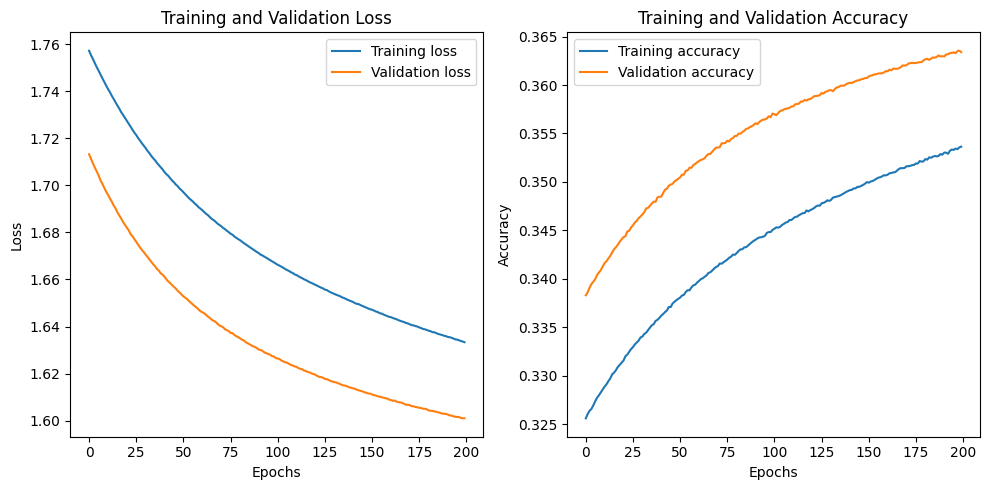

In [15]:
import matplotlib.pyplot as plt

# Plotting loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['loss'], label='Training loss')
plt.plot(hist.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting accuracy
plt.subplot(1, 2, 2)
plt.plot(hist.history['accuracy'], label='Training accuracy')
plt.plot(hist.history['val_accuracy'], label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [14]:
model.save('ae_model.keras')

In [3]:
import tensorflow as tf

2024-04-21 22:48:26.829864: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 22:48:26.829917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 22:48:26.831511: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [24]:
tf.saved_model.save(model, 'ae_model')

In [21]:
model = tf.saved_model.load('ae_model')

In [ ]:
converter = tf.lite.TFLiteConverter.from_saved_model('ae_model')
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS,
  tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()
with open('ae_model_opt.tflite', 'wb') as f:
    f.write(tflite_model)

In [3]:
import tensorflow as tf
model = tf.keras.models.load_model('/kaggle/working/ae_model.keras')

2024-04-21 21:44:42.152813: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-21 21:44:42.152873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-21 21:44:42.154310: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()
with open('ae_model_opt.tflite', 'wb') as f:
    f.write(tflite_model)

---